# Introduction to Time Series in Python

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

## Overview

- Time series is a sequence of data points ordered chronologically. Notice that we cannot randomly shuffle the data into trainig and test datasets. Instead, we split the datapoint by picking a cutoff time within the data.
- Each data point is associated with a timestamp.
- The interval between two data points is called **time-period**.
- **Frequency** refers to how often values a recorded ranging from milliseconds to years. We can adjust the frequency of a time-series by aggregating the data. We can decrease the frequency e.g. given a daily data, we can compute the averaged monthly. We can also increase the data by approximating or imputing datapoints between existing data points.
- Time periods between all data points must be equal i.e. have constant frequency. Otherwise we would have [missing values](https://stats.stackexchange.com/questions/121414/how-do-i-handle-nonexistent-or-missing-data). Dealing with missing values is complicated:

<img src="figures/time-series-missing-values.png" width="600" />

- Time series data does not satisfy [Gauss-Markov assumptions](https://www.statisticshowto.datasciencecentral.com/gauss-markov-theorem-assumptions/).
- Patterns observed in time series data in the past are expected to be present in the future.
- Data are usually **time-dependent**. This means that data points are affected by external factors and by the past periods. E.g. we expect tomorrows temperature outside to be within some reasonable proximity of the temperature today

Notation
- $\mathbf{X}$ denotes the data
- $T$ denotes the entire time span of the data
- $t$ a single period e.g. a single day
- $\mathbf{X}_t$ denotes the data for a single day

## Data Exploration

In [2]:
df_data = pd.read_csv('data/Index2018.csv')

In [3]:
df_data.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [4]:
df_data.dtypes

date       object
spx       float64
dax       float64
ftse      float64
nikkei    float64
dtype: object

Convert date to datetime type:

In [5]:
df_data.date = pd.to_datetime(df_data.date, dayfirst=True)

- Often dates are used as indices in time series data
- The data represents the closing prices for the four market indices:
  - **spx**: S&P 500 in US
  - **dax**: DAX 30 in Germany
  - **ftse**: FTSE 100 in the UK
  - **nikkei**: Nikkei 225 in Japan

Let us compute some statistics on the data:

In [6]:
df_data.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


The average spx value is much lower than the other indices. The maximum spx value is lower than the minimum values of ftse and nikkei. We have take it into account if we need to compare multiple time series.

In [7]:
df_data.date.describe()

count                    6269
unique                   6269
top       1999-08-23 00:00:00
freq                        1
first     1994-01-07 00:00:00
last      2018-01-29 00:00:00
Name: date, dtype: object

The entire period of this dataset is from 7th January 1994 to 29th Januar 2018.

We need to set the date column as index and set the frequency of the time series to be daily:

In [8]:
df_data.set_index('date', inplace=True)

In [9]:
df_data.asfreq('d').head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-08,NaN,NaN,NaN,NaN
1994-01-09,NaN,NaN,NaN,NaN
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25


The `asfreq` method generated new periods where no values are associated.

In [10]:
from datetime import datetime

In [11]:
datetime.strptime('1994-01-08', '%Y-%M-%d').strftime('%c')

'Sat Jan  8 00:01:00 1994'

Closing prices of the indices are only recorded when the financial markets are open. 

To avoid adding irrelevant periods, we can state tell Pandas that the data was recorded on business days with `df.asfreq('b')`:

In [12]:
df_data = df_data.asfreq('b')

In [13]:
df_data.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


### Missing Values

Let us determine the number of missing values.

In [14]:
df_data.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

There are eight time periods with no values. There are various ways to fill the missing values:

- Front filling: use the value of the previous period to fill the period with the missing value i.e. copies the last known value
- Back filling: use the value of the next period to fill the period with the missing value.
- Assign the same value to all periods with missing value. You could use the average value of the time series for filling missing values. But this is a bad approach for time series data because there are underlying time varient patterns in the data. This method is only appropriate if the data fluctuates heavily around the mean for the entire period of the time series. The code:
  ```python
  df_data.dax = df_data.dax.fillna(value=df_data.dax.mean())
  ```

In [15]:
df_data.spx = df_data.spx.fillna(method='ffill')  # bfill for back filling
df_data.ftse = df_data.ftse.fillna(method='ffill')
df_data.dax = df_data.dax.fillna(method='ffill')
df_data.nikkei = df_data.nikkei.fillna(method='ffill')

In [16]:
df_data.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

### Plotting

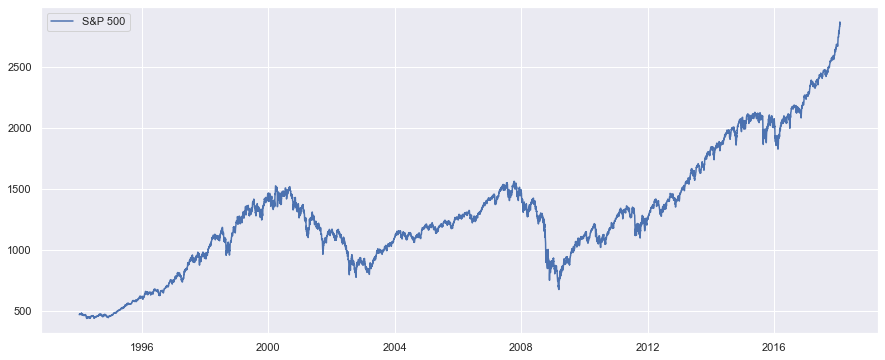

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df_data.spx, label='S&P 500')
ax.legend();

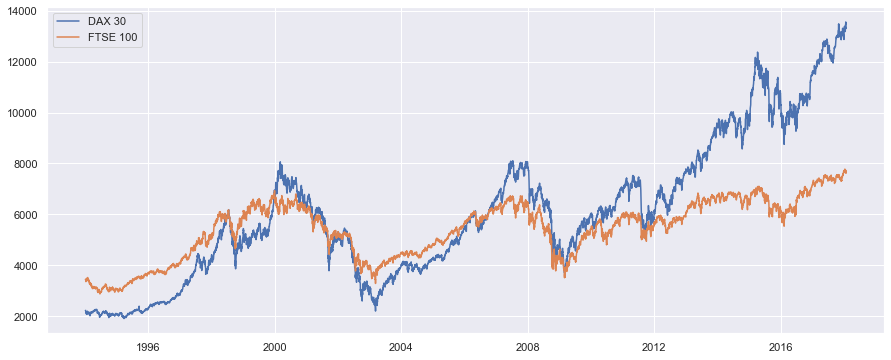

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df_data.dax, label='DAX 30')
ax.plot(df_data.ftse, label='FTSE 100')
ax.legend();

To look at the density of the data and which values are more likely to occur, we construct the Quantile-Quantile plot. The QQ plot allows us to determine the distribution of a time series data. It is used to determine if the data fits a normal distribution.

In [19]:
import scipy.stats as ss
import pylab

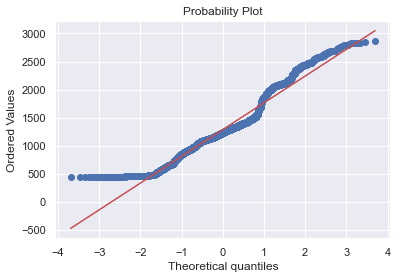

In [20]:
ss.probplot(df_data.spx, plot=pylab);

The QQ plot arranges all the values in accending order. The Y-axis expresses the price. The X-axis describes how the number of standard deviations the values are away from the mean. If the data points are on top of the red line then the data is normal distributed. Values around 500 deviate from the mean so we can concluse the the data is not follow the normal distribution. Therefore, we cannot use the nice properties of the normal distribution to make forecasts. More often than not, time series data is not normal distributed.

## Splitting Data

We cannot randomly shuffle time series data because data points are ordered chronologically and we want to preserve the order. To construct a train/test splits, we define a cut-off time where to place the split. We assume that patterns present in the train split (data in the past), will also be present in the test split (data in the future).

In [21]:
N_train_set = int(np.ceil(len(df_data) * 0.8))

In [22]:
N_train_set

5022

In [23]:
df_train = df_data.iloc[:N_train_set]

In [24]:
df_test = df_data.iloc[N_train_set:]

## White Noise

White noise is a special type of time series that does not contain any pattern. It is a sequence of random or arbitrary data. Therefore, it is unpredictable. There is no way to forecast or project the series into the future.

A random process is known as white noise if it exhibits the following characteristics:
- The mean $\mu$ is constant
- The variance $\sigma^2$ is constant
- No correlation between its values at different types (no auto-correlation) i.e. there is no clear relationship between the past and present values

White noise is important to understand before picking a model for a time series. 
In financial modelling, it is important to distinguish white noise from regular time series data. 
One way to see the difference is to plot the graphs.

In [25]:
train_mean = df_train.spx.mean()
wn = np.random.normal(loc=train_mean, scale=50, size=len(df_train))
with pd.option_context('mode.chained_assignment', None):
    df_train['wn'] = wn

In [26]:
df_train[['spx', 'wn']].mean()

spx    1091.745796
wn     1090.640965
dtype: float64

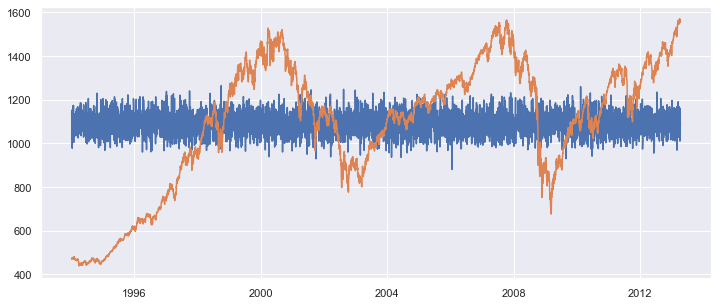

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_train.wn, label='White Noise')
ax.plot(df_train.spx, label='S&P 500 Closing Prices')

## Random Walk

Random walk is a special type of time series where values tend to persist over time. The differences between periods are simply white noise.

Given a time $t$ let $x_t$ represent some value and $\epsilon_t$ represent some residual at time $t$.

A random way is any process in which $x_t = x_{t-1} + \epsilon_t$ where $\epsilon_t ~ \mathcal{N}(\mu, \sigma^2)$ i.e. we assume that the residual is white noise.

This suggests that the best predictor of the value at the present time $t$, is the value at time $t-1$.

In [28]:
df_rw = pd.read_csv('data/RandWalk.csv')
df_rw.date = pd.to_datetime(df_rw.date, dayfirst=True)
df_rw.set_index('date', inplace=True)
df_rw = df_rw.asfreq('b')

In [29]:
df_rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


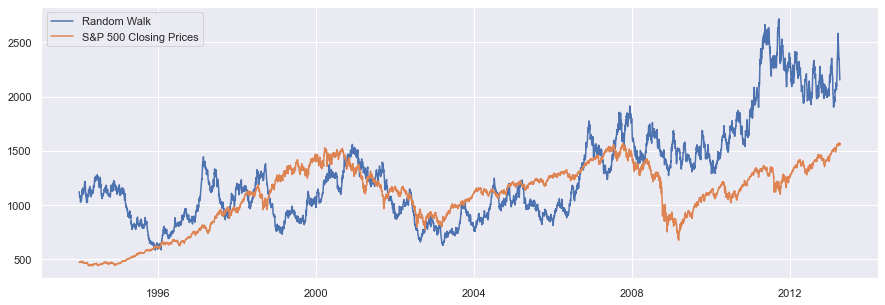

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_rw.price, label='Random Walk')
ax.plot(df_train.spx, label='S&P 500 Closing Prices')
ax.legend();

Looking at both time series, we observe:

- Both have small variations in the values over time
- Both have cyclical increases and decreases in short periods of time

The graph above indicates that it is difficult to distinguish the closing prices of the S&P 500 and random walk.

Since the prices resembles random walk, it becomes really hard to predict future prices.

Suppose some investors discover factors or information that can predict future prices with some level of accuracy.
In such case, it is safe to assume that the investors will take advantage of the situation.
Therefore, the information will be priced into the market.
This leads market efficiency.

Another related concept is arbitrage.
Arbitrage is a trade that seeks to "profits by exploiting the price differences of identical or similar financial instruments on different markets or in different forms. Arbitrage exists as a result of market inefficiencies and would therefore not exist if all markets were perfectly efficient." [Source Investopedia](https://www.investopedia.com/terms/a/arbitrage.asp).

## Stationarity

A stochastic process can be seen as a collection of time series sequences.
When we are given a specific time series data, it is a realisation of the process. 
Typically, we do not know the underlying stochastic process that generated the dataset.

The **covariance** of two stochastic random variables $\mathbf{X}$ and $\mathbf{Y}$ is given as:

\begin{align}
c_{xy} &= \text{cov}(\mathbf{X}, \mathbf{Y})  \\
 &= \mathbb{E}\left[ (\mathbf{X} - \mu_{X})(\mathbf{Y} - \mu_{Y})  \right] \\
 &= \mathbb{E}[\mathbf{X} \mathbf{Y}] - \mathbb{E}[\mathbf{X}] \mathbb{E}[\mathbf{Y}]
\end{align}

A time series is said to have (covariance) stationarity when:
- its mean is constant
- its variance is constant
- $Cov(X[M:M+k]) = Cov(X[N:N+k])$ i.e. the covariance between same-sized periods within the data is the same regardless of the starting time

A stochastic process is said to be **strict stationary** if same-sized periods i.e. $x[n_1], \cdots, x[n_p]$ and $x[n_1+k], \cdots, x[n_p+k]$ have the same joint probability distribution for any set of points $p$ and any shift $k$. [Source: Manolakis, Dimitris G., and Vinay K. Ingle. Applied digital signal processing: theory and practice](https://www.semanticscholar.org/paper/Applied-Digital-Signal-Processing%3A-Theory-and-Manolakis-Ingle/cb479a87b90a17847b2e4a3e9b481d8099ad5f50). This case is typically not observed in the real-world data series. We often use the weak/coveraince stationarity.

White noise satisfy the stationarity process because:
- its mean is 0
- its variance is constant (often 1)
- $Cov(X[M:M+k]) = Corr(X[M:M+k]) \mu_1 \mu_2 = 0$

To determine whether a given time series data follows a stationary stochastic process, we can use the DF-test or Dicky-Fuller test (developed by David Dickey and Wayne Fuller). An augmented test was developed to determine time-dependency in the data. 

The Dicky-Fuller test assumes non-stationarity. 
Concretely, the test's null-hypothesis assumes that one-lag autocorrelation coefficient is lower than one.
Once we compute the test statistic, we can compare it to the critical value in the Dickey-Fuller table.
If the test statistic is lower than the critical value, then we reject the null-hypothesis.
This means that the given data does not come from a non-stationary stochastic process.

In [31]:
# Run the Augmented Dickey-Fuller unit root test.
adf, pvalue, usedlag, nobs, critical_values, icbest = sts.adfuller(df_train.spx)

- `adf` is the test statistic. We compare this value to certain critical values to determine whether we have significant proof of stationarity
- `pvalue`: MacKinnon's approximate p-value associated with the t-statistic.
- `usedlag`: number of lags used in the regression when determining the t-statistic. We need to take this into account when picking an appropriate model.
- `nobs`: number of observations used in the analysis
- `critical_values`: critical values for the test statistic at the 1%, 5 %, and 10 % levels. These values are from the Dickey-Fuller table. We can use these values as levels of significance in our analysis.
- `icbest`: estimates the maximized information criterion if autolag is not None. The lower the values, the easier it is to make predictions for the future data.

The values `nobs` and `usedlag` should add up to the size of the dataset.  

In [32]:
(nobs + usedlag + 1) == len(df_train)

True

In [33]:
print('Test statistic: {}.\nCritical values: {}'.format(adf, critical_values))

Test statistic: -1.7217321349923942.
Critical values: {'1%': -3.4316577470238654, '5%': -2.862117882848672, '10%': -2.5670776077279878}


The test statistic is greater than any of the critical values.

In [34]:
print('p-value: {}'.format(pvalue))

p-value: 0.41995163848083494


The p-value suggests that there is approximately 41% chance of not rejecting the null-hypothesis.

This means that we cannot confirm that the data is stationary.

How do we interpret a p-value of 0.04 as an outcome of the Augmented Dickey-Fuller test?
- The data in question is stationary, assuming 5% significance.

### White Noise

Let us compare it to white nose which we know is a stationary process.

In [35]:
# Run the Augmented Dickey-Fuller unit root test.
adf, pvalue, usedlag, nobs, critical_values, icbest = sts.adfuller(df_train.wn)

In [36]:
print('Test statistic: {}.\nCritical values: {}\np-value: {}'.format(adf, critical_values, pvalue))

Test statistic: -51.491427437876986.
Critical values: {'1%': -3.431653316130827, '5%': -2.8621159253018247, '10%': -2.5670765656497516}
p-value: 0.0


The p-value is close to zero. 

Since there is no correlation in white noise, there should be no lags in the regression

In [37]:
print('Used lags: {}'.format(usedlag))

Used lags: 1


### Random Walk

Often random walk data sequences of the same size differ significantly. The covariance of two same-sized intervals would rarely be equal. 

Unlike white noise, we expect a random walk to be a non-stationary process.

In [38]:
# Run the Augmented Dickey-Fuller unit root test.
adf, pvalue, usedlag, nobs, critical_values, icbest = sts.adfuller(df_rw.price)

In [39]:
print('Test statistic: {}.\nCritical values: {}\np-value: {}'.format(adf, critical_values, pvalue))

Test statistic: -1.32860739276897.
Critical values: {'1%': -3.4316595802782865, '5%': -2.8621186927706463, '10%': -2.567078038881065}
p-value: 0.6159849181617392


Based on the p-value, there is 61% likelihood that the random walk data comes from a non-stationary stochastic process.

So we do not have significant evidence to say that the random walk data is stationary.

## Seasonality

Seasonality refers to the periodic fluctuations of a time series in which the data contains cyclical trends that appear regularly and predictably. E.g. trends in temperature is based on the times of day and months of the year. These are two distinct seasonal patterns that everyone can observe in their daily lives. 

Another example is the arrival of swimwear in the US:

<img src="figures/edited-apparel-seasonality.jpeg" width="600" />

Seasonality is not a trait of cross-sectional data because there are no chronological order in these data.

We must consider seasonal patterns and take them into account when making predictions.



### Naive Decomposition

Testing for seasonality can be done in several ways.

One way is to decompose the sequence into three effects:
  1. Trends represent the patterns that are consistently observed in the data
  2. Seasonal expresses cyclical effects to the seasonality
  3. Residual represents the difference between the actual data and the output of the fitted model

A naive decomposition assumes that there is a linear relationship between three effects in the given time series.

There are two main approaches to the naive decomposition:
- Additive approach assumes that any observed value in the time series is the sum of the trend, seasonale and residual
- Multiplicative method assumes that the observed value is the product of the trend, seasonale and residual

We can use the `seasonal_decompose` function in `statsmodels.tsa.seasonal` Python package.

In [40]:
sd_additive = seasonal_decompose(df_train.spx, model='additive')

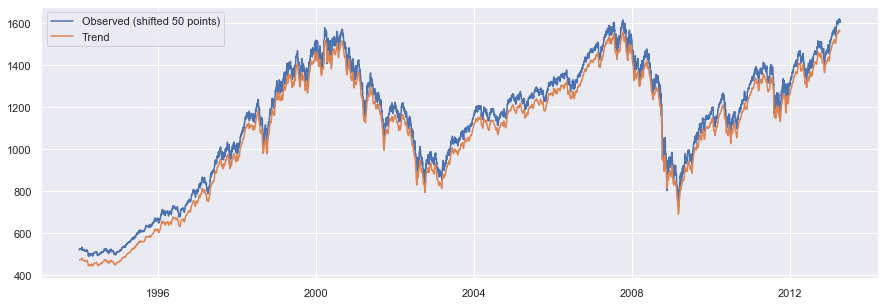

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sd_additive.observed+50, label='Observed (shifted 50 points)')
ax.plot(sd_additive.trend, label='Trend')
ax.legend()

Notice that the trend closely resembles the observed time series. The `seasonal_decompose` function uses the previous value as a trend-setter. Assuming the closing prices of the stock market is a random walk, we know that the best predictor of the value at the present time $x[n]$, is the value at preceding time $x[n-1]$. If we observe seasonal patterns, other factors will be better predictors. For example, if prices are consistently higher at the beginning of the month compared to the end, then the best predictor of future price might be $x[n-30]$. The trend explains most of the variability of the data. 

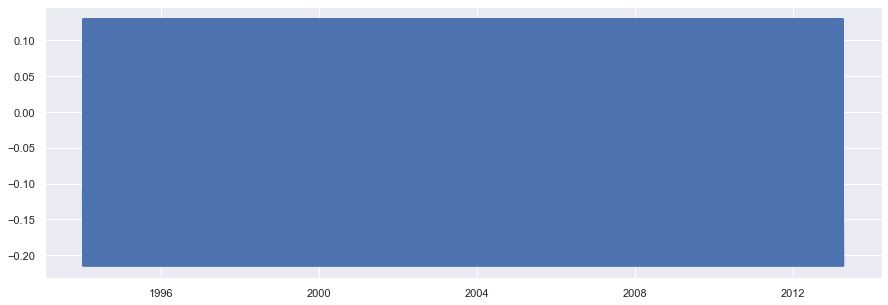

In [42]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sd_additive.seasonal, label='Seasonal');

The seasonal plot looks like a rectangle because the values are fluctuating between -0.2 to +0.1 for every time step. We cannot see this because the figure size is too small. This indicates there are no cyclical patterns using the naive decomposition. 

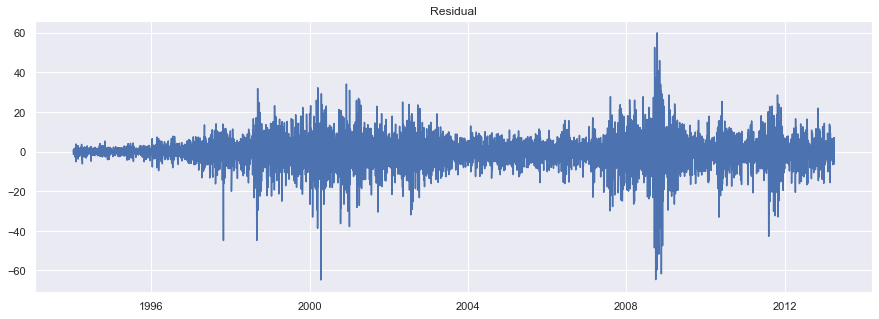

In [43]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sd_additive.resid)
ax.set_title('Residual');

The residual plot shows the errors of the fitted model. A residual is the difference between the true value and the prediction of the fitted model. Interestingly, the residuals vary greatly after 2000 and 2008. This can be explained by the instability caused by the dotcom and housing prices bubbles, respectively.

Overall, the result of the additive decomposition suggests no seasonality of the data.

We can double-check this result by trying the multiplicative decomposition.

In [44]:
sd_multiplicative = seasonal_decompose(df_train.spx, model='multiplicative')

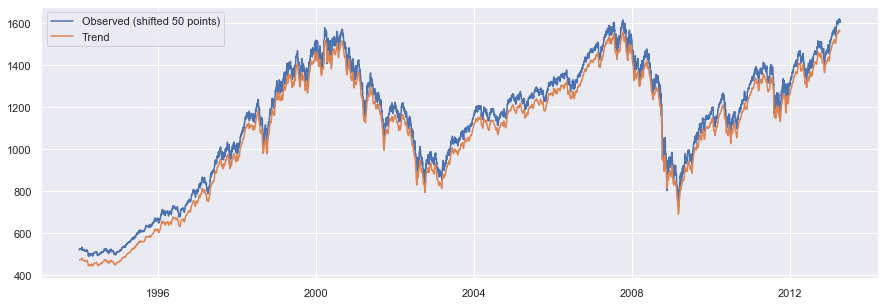

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sd_multiplicative.observed+50, label='Observed (shifted 50 points)')
ax.plot(sd_multiplicative.trend, label='Trend')
ax.legend()

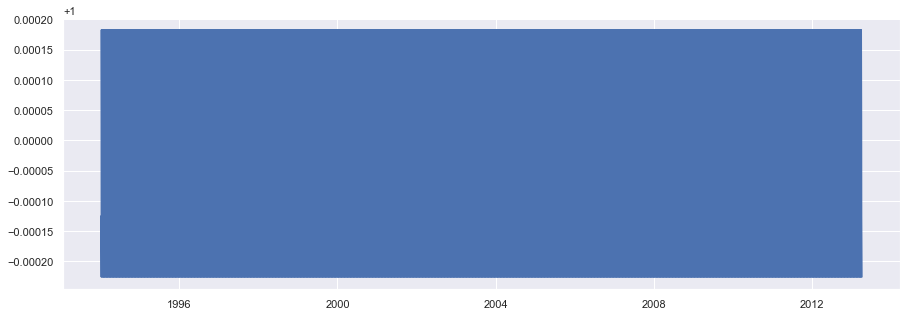

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sd_multiplicative.seasonal, label='Seasonal');

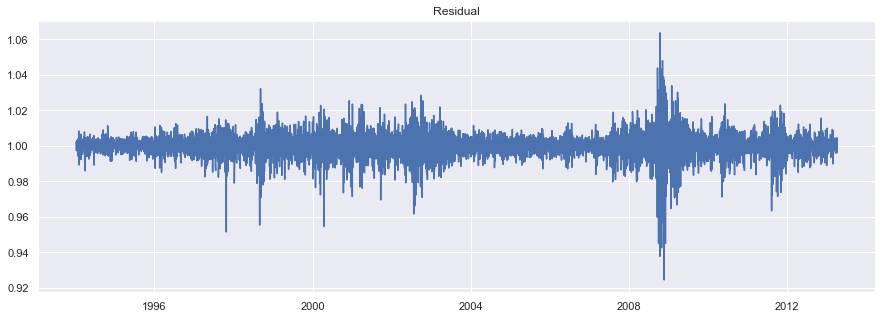

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sd_multiplicative.resid)
ax.set_title('Residual');

We see similar result suggesting that there is no seasonality.